In [1]:
script = False
cluster = False

import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
plt.style.use('dark_background')
import random
from scipy.stats import skewnorm
import copy
from distutils.util import strtobool

if(script): 
    from tqdm import tqdm
else:
    from tqdm.notebook import tqdm
    import ipython_bell

from astropy.io import fits
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
from astropy.visualization import make_lupton_rgb

import lenstronomy.Util.param_util as param
import lenstronomy.Util.util as util
import lenstronomy.Plots.plot_util as plot_util
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver

import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
DES_camera = {'read_noise': 7.,  # std of noise generated by read-out (in units of electrons)
               'pixel_scale': 0.2637,  # scale (in arcseconds) of pixels
               'ccd_gain': 4.#6.  # electrons/ADU (analog-to-digital unit). A gain of 8 means that the camera digitizes the CCD signal so that each ADU corresponds to 8 photoelectrons.
              }

DES_g_band_obs = {'exposure_time': 90.,  # exposure time per image (in seconds)
                   'sky_brightness': 35.01,  # sky brightness (in magnitude per square arcseconds)
                   'magnitude_zero_point': 30,  # magnitude in which 1 count per second per arcsecond square is registered (in ADU's)
                   'num_exposures': 10.,  # number of exposures that are combined
                   'seeing': 1.12,  # full width at half maximum of the PSF (if not specific psf_model is specified)
                   'psf_type': 'GAUSSIAN',  # string, type of PSF ('GAUSSIAN' and 'PIXEL' supported)
                   'kernel_point_source': None  # 2d numpy array, model of PSF centered with odd number of pixels per axis (optional when psf_type='PIXEL' is chosen)
                  }

DES_r_band_obs = {'exposure_time': 90.,  
                   'sky_brightness': 34.7,  
                   'magnitude_zero_point': 30,  
                   'num_exposures': 10.,  
                   'seeing': 1.12,  
                   'psf_type': 'GAUSSIAN', 
                  }

DES_i_band_obs = {'exposure_time': 90.,  
                   'sky_brightness': 35.1,  
                   'magnitude_zero_point': 30,  
                   'num_exposures': 10.,  
                   'seeing': 1.12,  
                   'psf_type': 'GAUSSIAN', 
                  }

numpix = 45 # 45

kwargs_g_band = util.merge_dicts(DES_camera, DES_g_band_obs)
kwargs_r_band = util.merge_dicts(DES_camera, DES_r_band_obs)
kwargs_i_band = util.merge_dicts(DES_camera, DES_i_band_obs)

kwargs_numerics = {'point_source_supersampling_factor': 10}

cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)

In [3]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

In [4]:
#Distribution that includes more positions further away from the center
def pick_center(ra_caustic_list, dec_caustic_list):
    l = random.randint(0, len(ra_caustic_list)-1)
    t = skewnorm.rvs(a=-5, size=10000, loc=0.8, scale=0.435) #a: skew, loc: center, scale:sigma
    noise_ra, noise_dec = t[np.random.randint(0,10000)], t[np.random.randint(0,10000)]
    s_ra = 1 if random.randint(0, 1) else -1
    s_dec = 1 if random.randint(0, 1) else -1
    noise_ra, noise_dec = s_ra*noise_ra, s_dec*noise_dec
    return(ra_caustic_list[l] + noise_ra, dec_caustic_list[l] + noise_dec)

In [5]:
#Plots image of complete simulation
def plot_image(sim_g, sim_r, sim_i):
    loc = plticker.MultipleLocator(base=3.75)
    fig, (ax1) = plt.subplots(figsize=(15, 4), ncols=1)

    rgb = make_lupton_rgb(sim_i, sim_r, sim_g, Q=11., stretch=40.)
    ax1.set_title('Complete Simulation')
    ax1.xaxis.set_ticklabels([])
    ax1.yaxis.set_ticklabels([])
    original = ax1.imshow(rgb, aspect='equal')
   
    sub_path = '/Users/jimenagonzalez/research/DSPL/Simulations-Double-Source-Gravitational-Lensing/'
    #plt.savefig(sub_path + 'Data/Sim_complete/Image' + name + '.png', bbox_inches='tight')
    plt.show()
    
def lenstronomy_plot(image_g, image_r, image_i):
    img = np.zeros((image_g.shape[0], image_g.shape[1], 3), dtype=float)
    img[:,:,0] = plot_util.sqrt(image_g, scale_min=0, scale_max=1000)
    img[:,:,1] = plot_util.sqrt(image_r, scale_min=0, scale_max=1000)
    img[:,:,2] = plot_util.sqrt(image_i, scale_min=0, scale_max=1000)
    
    plt.clf()
    #plt.figure(figsize=(5, 5))
    plt.imshow(img, aspect='equal', origin='lower')
    plt.show()

#Makes 3 plots per image: source simulation, lens cutout, complete simulation
def make_graphs(name, sim_i, sim_r, sim_g, cutout_i, cutout_r, cutout_g):
    loc = plticker.MultipleLocator(base=3.75)
    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15, 4), ncols=3)

    rgb = make_lupton_rgb(sim_i, sim_r, sim_g, Q=11., stretch=40.)
    ax1.set_title('Lens galaxy simulation')
    ax1.xaxis.set_ticklabels([])
    ax1.yaxis.set_ticklabels([])
    original = ax1.imshow(rgb, aspect='equal')

    rgb = make_lupton_rgb(cutout_i, cutout_r, cutout_g, Q=11., stretch=40.)
    ax2.set_title('Real lens galaxy')
    ax2.xaxis.set_ticklabels([])
    ax2.yaxis.set_ticklabels([])
    cutout = ax2.imshow(rgb, aspect='equal')
            
    rgb = make_lupton_rgb(sim_i+cutout_i, sim_r+cutout_r, sim_g+cutout_g, Q=11., stretch=40.)
    ax3.set_title('Nothing')
    ax3.xaxis.set_ticklabels([])
    ax3.yaxis.set_ticklabels([])
    projection = ax3.imshow(rgb, aspect='equal')
   
    sub_path = '/Users/jimenagonzalez/research/DSPL/Simulations-Double-Source-Gravitational-Lensing/'
    #plt.savefig(sub_path + 'Data/Sim_complete/Image' + name + '.png', bbox_inches='tight')
    plt.show()

In [6]:
# Writes fit file
def write_fit_file(name, x, data):
    my_types = {'Y6_COADD_OBJECT_ID': int, 'TILENAME': str, 'HPIX_16384': int, 'HPIX_4096': int,
       'DNF_ZMEAN_SOF': float, 'RA': float, 'DEC': float, 'FLUX_RADIUS_G': float, 'FLUX_RADIUS_R': float,
       'FLUX_RADIUS_I': float, 'FLUX_RADIUS_Z': float, 'KRON_RADIUS': float, 'GAP_FLUX_G': float,
       'MOF_BDF_FLUX_G': float, 'MOF_PSF_FLUX_G': float, 'SOF_BDF_FLUX_G': float, 'SOF_PSF_FLUX_G': float,
       'MAG_AUTO_G': float, 'MAG_APER_4_G': float, 'MAG_APER_8_G': float, 'SOF_BDF_G_1': float,
       'Y3_COADD_OBJECT_ID': int, 'REFMAG': float, 'REFMAG_ERR': float, 'LUM': float, 'ZREDMAGIC': float,
       'ZREDMAGIC_E': float, 'CHISQ': float, 'Z_LENS': float, 'MAG_G': float, 'MAG_R': float, 'MAG_I': float, 'MAG_Z': float,
       'MAG_ERR_G': float, 'MAG_ERR_R': float, 'MAG_ERR_I': float, 'MAG_ERR_Z': float, 'ZG': float, 'ZR': float, 'ZI': float,
       'ZZ': float, 'SOF_BDF_G_2': float, 'IMAFLAGS_ISO_G': int, 'IMAFLAGS_ISO_R': int,
       'IMAFLAGS_ISO_I': int, 'IMAFLAGS_ISO_Z': int, 'EXT_COADD': int, 'FWHM_WMEAN_G': float,
       'FWHM_WMEAN_R': float, 'FWHM_WMEAN_I': float, 'FWHM_WMEAN_Z': float, 'SKYBRITE_WMEAN_G': float,
       'SKYBRITE_WMEAN_R': float, 'SKYBRITE_WMEAN_I': float, 'SKYBRITE_WMEAN_Z': float, 'Z1': float, 'LENSED_MAG': float,     
       'mag_1': float, 'ISOLATION': float, 'EINSTEIN_RADIUS': float, 'MAGNIFICATION': float, 'POSITION1': float}
    if(double):
        tmp_types = {'Z2': float, 'mag_2': float, 'POSITION2': float, 'dif_color': float}
        my_types.update(tmp_types)
    data = data.astype(my_types)
    
    primary = fits.PrimaryHDU()
    image = fits.ImageHDU(x, name="IMAGE")
    table_data = Table.from_pandas(data)
    table = fits.BinTableHDU(data = table_data)
    hdu_list = fits.HDUList([primary, image, table])
    hdu_list.writeto(file_path + name + '.fits', overwrite=True)   
    hdu_list.close()

In [7]:
#Calculating distance of the furtherst image to the lens center
def furtherst_distance(theta_ra, theta_dec):
    distances_list = []
    for i in range(len(theta_ra)):
        distances_list.append(np.sqrt(theta_ra[i]**2 + theta_dec[i]**2))
    return(max(distances_list))


#Calculating ~total flux
def calculate_flux(object, band):
    flux = np.sum(object[band])
    return(flux)

#Calculating AB magnitude
def calculate_magnitude(object, band):
    f = calculate_flux(object, band)
    m = -2.5*np.log10(f*10**(-12))
    return(m)

def calculate_magnification(delta_m):
    M = 100**(delta_m/5)
    return(M)

def isolation(image_source, image_lens, cumulative=0.9):
    """Compute a statistic to measure degree of source image isolation.
   
    Use the simulated image of the lensed source to define an effective weight
    map. Use the weight map to compute the weighted average flux within pixels 
    from the lensed source images and from the foreground lens. Return the 
    effective fraction of the total flux within this weighted aperture that is
    attributed to the source.

    isolation = <source_flux> / (<source_flux> + <lens_flux>)
 
    A weighted aperture is obtained by converting the simulated source image 
    into a PDF, removing the set of faint pixels that contain (1 - cumulative)
    of the total flux, and normalizing the weighted aperture such that integral 
    over all pixels in equal to one.

    Parameters
    ----------
    image_source : `numpy.ndarray` [`float`]
        Image of simulated lensed source; shape (n, n)
    image_lens : `np.ndarray` [`float`]
        Image of lens and other foreground objects; shape (n, n)
    cumulative : `float`
        Fraction of lens total flux to use when defining an aperture. 
        Default = 0.9.
    
    Returns
    -------
    isolation : `float`
        Mean flux fraction attributed to the source images within the weighted
        apertue.
    """
    
    weight = image_source  / np.sum(image_source)
    weight_sorted = np.sort(weight.flatten())
    threshold = weight_sorted[np.cumsum(weight_sorted) > (1. - cumulative)][0]
    aperture = weight > threshold

    weight_aperture = weight * aperture / np.sum(weight * aperture)

    mean_lens = np.sum(weight_aperture * image_lens) 
    mean_sources = np.sum(weight_aperture * image_source)
    isolation = mean_sources / (mean_sources + mean_lens)
    return isolation

# From redshift get magnitude, sersic radius & ellipticity
def distribution(z, data):
    dz = 0.1 # Range of redshift for filtering
    new_data = data[data['DNF_ZMEAN_SOF'] > z - dz] [data['DNF_ZMEAN_SOF'] < z + dz] 
    new_data = new_data[new_data['MAG_PSF_G'] < MMAX]
    if(double):
        new_data = new_data[new_data['MAG_PSF_G'] > MMIN]
    random_object = new_data.sample()
    mg, mr, mi = random_object['MAG_PSF_G'].values[0], random_object['MAG_PSF_R'].values[0], random_object['MAG_PSF_I'].values[0]
    rg, rr, ri = random_object['FLUX_RADIUS_G'].values[0], random_object['FLUX_RADIUS_R'].values[0], random_object['FLUX_RADIUS_I'].values[0]
    e1, e2 = random_object['SOF_CM_G_1'].values[0], random_object['SOF_CM_G_2'].values[0]
    magnitude = {'mg': mg -1., 'mr': mr-1., 'mi': mi-1.}
    radius = {'rg': rg*DES_camera['pixel_scale'], 'rr': rr*DES_camera['pixel_scale'], 'ri': ri*DES_camera['pixel_scale']}
    ellipticity = {'e1': e1, 'e2': e2}
    return(magnitude, radius, ellipticity)
    #z = 1.7 Max

def distribution_data(path):
    data_dist = pd.read_csv(path)
    data_dist = data_dist[data_dist['MAG_PSF_G'] < 30.] [data_dist['MAG_PSF_R'] < 30.] [data_dist['MAG_PSF_I'] < 30.]
    data_dist = data_dist[data_dist['SOF_CM_G_1'] > -100.][data_dist['SOF_CM_G_2'] > -100.]
    data_dist = data_dist[data_dist['DNF_ZMEAN_SOF'] > 0.01][data_dist['DNF_ZMEAN_SOF'] < 2.9]
    data_dist = data_dist.sort_values('DNF_ZMEAN_SOF').reset_index()
    return(data_dist)


In [8]:
def simulation(model, coadd_id, redshifts, lens_image, lens, cuts, double, additional_info, kwargs_bands):
   
    kwargs_model_physical = {'lens_model_list': ['SIE'],  # list of lens models to be used
                          'lens_redshift_list': [redshifts['lens']],  # list of redshift of the deflections
                          # list of extended source models to be used
                            'lens_light_model_list': ['SERSIC_ELLIPSE'], 
                          'source_light_model_list': ['SERSIC_ELLIPSE'],  
                          # list of redshfits of the sources in same order as source_light_model_list
                          'source_redshift_list': [redshifts['source1']],  
                          'cosmo': cosmo,  # astropy.cosmology instance
                          # redshift of the default source (if not further specified by 'source_redshift_list')
                          'z_source': redshifts['source1']} 
                           #and also serves as the redshift of lensed point sources}
    
    kwargs_g_band, kwargs_r_band, kwargs_i_band = kwargs_bands[0], kwargs_bands[1], kwargs_bands[2]
    
    sim_g = SimAPI(numpix=numpix, kwargs_single_band=kwargs_g_band, kwargs_model=kwargs_model_physical)
    sim_r = SimAPI(numpix=numpix, kwargs_single_band=kwargs_r_band, kwargs_model=kwargs_model_physical)
    sim_i = SimAPI(numpix=numpix, kwargs_single_band=kwargs_i_band, kwargs_model=kwargs_model_physical)
    
    imSim_g = sim_g.image_model_class(kwargs_numerics)
    imSim_r = sim_r.image_model_class(kwargs_numerics)
    imSim_i = sim_i.image_model_class(kwargs_numerics)

    #lens mass model
    kwargs_mass = [{'sigma_v': lens['sigma'], 'center_x': 0, 'center_y': 0, 
                    'e1': lens['e1'], 'e2': lens['e2']}]
    kwargs_lens = sim_g.physical2lensing_conversion(kwargs_mass=kwargs_mass)
    
    #caustics and critical curves
    ra_crit_list, dec_crit_list, ra_caustic_list, dec_caustic_list = model['model_ext'].critical_curve_caustics(kwargs_lens, 
                                                                compute_window=15, grid_scale=0.01, center_x=0, center_y=0)
    if(len(ra_caustic_list)==0): return('No caustics')
    ra_caustic_list, dec_caustic_list = ra_caustic_list[0], dec_caustic_list[0]
    
    #cut on the Einstein radius of the lens
    if(kwargs_lens[0]['theta_E'] < cuts['E_min'] or kwargs_lens[0]['theta_E'] > cuts['E_max']):
        return ('No cut E: {:.3f}'.format(kwargs_lens[0]['theta_E']))
    
    #cut comparing Einstein radius and size of the lens
    E_rflux = kwargs_lens[0]['theta_E']/additional_info['FLUX_RADIUS_G']
    if(E_rflux < cuts['theta_E_r_f_min'] or E_rflux > cuts['theta_E_r_f_max']):
        return ('No cut E_r: {:.3f}'.format(E_rflux))
    
    #lens light
    kwargs_lens_light_mag_g = [{'magnitude': lens['mag_g'], 'R_sersic': lens['R_sersic'], 'n_sersic': lens['n_sersic'], 
                                'e1': lens['e1_light'], 'e2': lens['e2_light'], 'center_x': 0, 'center_y': 0}]
    kwargs_lens_light_mag_r = copy.deepcopy(kwargs_lens_light_mag_g)
    kwargs_lens_light_mag_r[0]['magnitude'], kwargs_lens_light_mag_r[0]['R_sersic'] = lens['mag_r'], lens['R_sersic']
    kwargs_lens_light_mag_i = copy.deepcopy(kwargs_lens_light_mag_g)
    kwargs_lens_light_mag_i[0]['magnitude'], kwargs_lens_light_mag_i[0]['R_sersic'] = lens['mag_i'], lens['R_sersic']
    
    #First source light distributions & colors of the other bands for each source
    mag1, rad1, ellip1 = distribution(redshifts['source1'], data = data_dist)
    n1 = random.uniform(0.3, 4.)
    #Pick center of first source very close to the caustic
    c1x, c1y = pick_center(ra_caustic_list, dec_caustic_list)
    
    theta_ra1, theta_dec1 = model['solver'].image_position_from_source(c1x, c1y, kwargs_lens)
    if(len(theta_ra1)==0): return('No image positions')
    #magni1 = model['lensModel'].magnification(theta_ra1, theta_dec1, kwargs_lens)
    
    distance1 = furtherst_distance(theta_ra1, theta_dec1)
    if(distance1 < cuts['min_image'] or distance1 > cuts['max_image']):
        return('No cut image: {:.3f}'.format(distance1))
    
    
    #Source light:
    kwargs_source_mag_g = [{'magnitude': mag1['mg']+8, 'R_sersic': rad1['rg'], 'n_sersic': n1,
                              'e1': ellip1['e1'], 'e2': ellip1['e2'], 'center_x': c1x, 'center_y': c1y}]
    #Adding color distribution to the bands (first source):
    kwargs_source_mag_r = copy.deepcopy(kwargs_source_mag_g)
    kwargs_source_mag_r[0]['magnitude'], kwargs_source_mag_r[0]['R_sersic'] = mag1['mr']+8, rad1['rr']
    kwargs_source_mag_i = copy.deepcopy(kwargs_source_mag_g)
    kwargs_source_mag_i[0]['magnitude'], kwargs_source_mag_i[0]['R_sersic'] = mag1['mi']+8, rad1['ri']
    
    kwargs_lens_light_g, kwargs_source_g , point = sim_g.magnitude2amplitude(kwargs_lens_light_mag=kwargs_lens_light_mag_g, 
                                                    kwargs_source_mag=kwargs_source_mag_g, kwargs_ps_mag=None)
    kwargs_lens_light_r, kwargs_source_r , point = sim_r.magnitude2amplitude(kwargs_lens_light_mag=kwargs_lens_light_mag_r, 
                                                    kwargs_source_mag=kwargs_source_mag_r, kwargs_ps_mag=None)
    kwargs_lens_light_i, kwargs_source_i , point = sim_i.magnitude2amplitude(kwargs_lens_light_mag=kwargs_lens_light_mag_i, 
                                                    kwargs_source_mag=kwargs_source_mag_i, kwargs_ps_mag=None)
    
    image_g = imSim_g.image(kwargs_lens, kwargs_source_g, kwargs_lens_light_g)
    image_r = imSim_r.image(kwargs_lens, kwargs_source_r, kwargs_lens_light_r)
    image_i = imSim_i.image(kwargs_lens, kwargs_source_i, kwargs_lens_light_i)
    
    image_g += sim_g.noise_for_model(model=image_g)
    image_r += sim_r.noise_for_model(model=image_r)
    image_i += sim_i.noise_for_model(model=image_i)
    
    #lenstronomy_plot(image_g, image_r, image_i)
    
    #image_g = image_g[::-1]
    #image_r = image_r[::-1]
    #image_i = image_i[::-1]
    
    
    if(np.isnan(np.sum(image_g))): 
        return('IS NAN!!!!!')
    
    object_sim = np.array([image_g, image_r, image_i])
    m = calculate_magnitude(object_sim, 0) #band 0 = g band

    if((m > cuts['mmax'] or m < cuts['mmin']) and double == False):
        return ('No cut mag: {:.3f}'.format(m))
    
    lens_g, lens_r, lens_i = lens_image[0], lens_image[1], lens_image[2]
    iso_g, iso_i, iso_r = isolation(image_g,lens_g), isolation(image_i, lens_i), isolation(image_r, lens_r)
    iso_ave = np.mean([iso_g, iso_i, iso_r])
    Mag = calculate_magnification(mag1['mg'] - m)
    
    if(iso_ave < cuts['iso_min'] or iso_ave > cuts['iso_max'] or np.isnan(iso_ave)): 
        return('No cut isolation: {:.3f}'.format(iso_ave))
    
    if(Mag < cuts['magni_min'] or Mag > cuts['magni_max'] or np.isnan(Mag)): 
        return('No cut magnification: {:.3f}'.format(Mag))
    
    parameters = {'Z1': redshifts['source1'], 'LENSED_MAG': m, 'mag_1': mag1['mg'], 
                  'ISOLATION': iso_ave, 'EINSTEIN_RADIUS': kwargs_lens[0]['theta_E'], 'MAGNIFICATION': Mag,
                 'POSITION1': distance1}
        
    tmp_series = pd.Series(parameters)
    additional_info = pd.concat([additional_info, tmp_series])
    df_test = pd.DataFrame(additional_info).transpose()
    parameters = df_test
    
    #ele_sim = np.array([image_g + lens_g, image_r + lens_r, image_i + lens_i])
    ele_sim = np.array([image_g, image_r, image_i])
    ele_sim = np.rot90(ele_sim, k=random.randint(0, 4), axes=(1, 2))
    if(random.randint(0, 1) == 1): ele_sim = np.flip(ele_sim, 2)
    print(coadd_id)
    """
    print('Lensed mag: ', m)
    print('Velocity of dispersion: ', lens['sigma'])
    print('Color difference: ', color_dif)
    print('Distance 1: ', distance1)
    print('Distance 2: ', distance2)
    print('Diference redshift: ', redshifts['source2'] - redshifts['source1'])
    print('Diference distance: ', abs(distance1 - distance2))
    """
    if(not script):
        print(lens['n_sersic'], lens['R_sersic'])
        #print('z: {:.3f}, mag_g: {:.2f}, R_sersic: {:.2f}, n: {:.2f}, e1: {:.2f}, e2: {:.2f}'.format(redshifts['lens'], 
        #            mag['mg'], rad['rg'], n, ellip['e1'], ellip['e2']))
        make_graphs('example_simulations', image_g, image_r, image_i, lens_i, lens_r, lens_g)
        
    return ('ok', ele_sim, parameters)

In [9]:
def simulations_from_data(lenses, complete_data, num, double):
    num_sim = 0
    r_var = 0.
    images_sim = np.zeros((1,3,numpix,numpix))
    data_sim = pd.DataFrame()

    lens_model_list = ['SIE']
    lensModel = LensModel(lens_model_list=lens_model_list)
    lensModelExt = LensModelExtensions(lensModel)
    solver = LensEquationSolver(lensModel)
    
    model = {'lensModel': lensModel, 'model_ext': lensModelExt, 'solver': solver}
    
    with tqdm(total=num) as pbar:
        while (num_sim < num):
            l = random.randint(0, len(complete_data)-1)
            row = complete_data.iloc[l]
            lens_image = lenses[l]
            
            DES_g_band_obs['seeing'] = row['FWHM_WMEAN_G'] 
            DES_r_band_obs['seeing'] = row['FWHM_WMEAN_R']
            DES_i_band_obs['seeing'] = row['FWHM_WMEAN_I']
            
            DES_g_band_obs['sky_brightness'] = 22.05 #row['SKYBRITE_WMEAN_G']/26
            DES_r_band_obs['sky_brightness'] = 21.18 #row['SKYBRITE_WMEAN_R']/64
            DES_i_band_obs['sky_brightness'] = 19.92 #row['SKYBRITE_WMEAN_I']/84
            
            
            kwargs_g_band = util.merge_dicts(DES_camera, DES_g_band_obs)
            kwargs_r_band = util.merge_dicts(DES_camera, DES_r_band_obs)
            kwargs_i_band = util.merge_dicts(DES_camera, DES_i_band_obs)
            
            kwargs_bands = [kwargs_g_band, kwargs_r_band, kwargs_i_band]

            coadd_id = int(row['Y6_COADD_OBJECT_ID'])
            z_lens = row['Z_LENS']
            z1_max = skewnorm.rvs(a=-5, size=10000, loc=1.2, scale=0.4)  #0.2, 1.2   0.8 for DSPL
            z1_max = z1_max[np.random.randint(0,1000)]
            z_source1 = z_lens + z1_max # 1.2
            z_source2 = random.uniform(z_source1 + 0.1, 2.) # 0.35
            if(z_lens < 0.15): continue
            if(z1_max < 0.2 or z_source1 > 2.): continue
            
            redshifts = {'lens': z_lens, 'source1': z_source1, 'source2': z_source2}
            angle, ratio = param.ellipticity2phi_q(row['SOF_BDF_G_1'], row['SOF_BDF_G_2'])
            #angle += 0.698132*random.uniform(-1, 1) #noise between -40 and 40 degrees
            #ratio = random.uniform(0.001, 1) #distribution for the axis ratio #TEST AKDLSMFALKDMFLK
            e1, e2 = param.phi_q2_ellipticity(angle, ratio)
            #light distribution for lens
            mag, rad, ellip = distribution(redshifts['lens'], data = data_dist)
            mag = {'mg': row['MAG_I'], 'mr': row['MAG_R'], 'mi': row['MAG_G']}
            #mag = {'mg': 18, 'mr': 19, 'mi': 20}
            n = r_var #random.uniform(0., 3.5)
            n = random.uniform(0.8, 4.3)
            #rad = {'rg': 1.}
            #rad = {'rg': random.uniform(0.6, 2.)}
            rad = {'rg': row['FLUX_RADIUS_G']*0.2637}
            
            lens = {'sigma': random.uniform(300, 570), 'e1': e1, 'e2': e2, 'mag_g': mag['mg'], 'mag_r': mag['mr'],
                    'mag_i': mag['mi'], 'R_sersic': rad['rg'], 'n_sersic': n, 'e1_light': row['SOF_BDF_G_1'], 
                    'e2_light': row['SOF_BDF_G_2']} #single: 300-650
            #lens = {'sigma': random.uniform(300, 570), 'e1': e1, 'e2': e2, 'mag_g': mag['mg'], 'mag_r': mag['mr'],
            #        'mag_i': mag['mi'], 'R_sersic': rad['rg'], 'n_sersic': n, 'e1_light': 0.1, 
            #        'e2_light': 0} #single: 300-650
            status = simulation(model, coadd_id, redshifts, lens_image, lens, cuts, double, row, kwargs_bands)
            
            if(status[0] == 'ok'):
                ele_sim, parameters = status[1], status[2]
                images_sim = np.append(images_sim, [ele_sim], axis = 0)
                data_sim = data_sim.append(parameters, ignore_index=True)
                num_sim += 1
                pbar.update(1)
                
    images_sim = np.delete(images_sim, 0, axis = 0)
    return(images_sim, data_sim)

In [10]:
def run_everything(seed, num_sim, double, name_file):
    seed_everything(seed)

    hdu_list = fits.open(lenses_path)
    lenses = hdu_list[1].data 
    complete_data = hdu_list[2].data[:]
    complete_data = Table(complete_data)
    complete_data = complete_data.to_pandas()
    complete_data = complete_data.rename({'ZSPEC': 'Z_LENS'}, axis=1)
    print(len(complete_data))
    hdu_list.close()

    images_sim, data_sim = simulations_from_data(lenses, complete_data, num = num_sim, double=double)
    write_fit_file(name_file, images_sim, data_sim)

In [11]:
inipath = '/Users/jimenagonzalez/research/DSPL/Simulations-Double-Source-Gravitational-Lensing/'
path_dist = inipath + 'Data/source_distributions.csv'
lenses_path = inipath + 'Data/Sim_complete/new_all_redmagic/' + 'all_redmagic_final.fits'
file_path = 'Data/fit_files'

if(cluster):
    path_dist = 'source_distributions.csv'
    lenses_path = 'all_redmagic_final.fits' #'lenses_cutouts.fits'
    file_path = ''

data_dist = distribution_data(path_dist)
data_dist = data_dist[data_dist['MAG_PSF_G'] - data_dist['MAG_PSF_R'] > -2.2]
data_dist = data_dist[data_dist['MAG_PSF_R'] - data_dist['MAG_PSF_I'] > -2.2]

MMAX = 30
MMIN = 10
mmin, mmax, E_min, E_max, iso_min, iso_max, magni_min, magni_max = 0, 100000, 0., 100, 0., 1000000, 0, 10000000
theta_E_r_f_min, theta_E_r_f_max, min_image, max_image = 0., 10000., 0., 1000.
min_col = 0.3
cuts = {'E_max': E_max, 'E_min': E_min, 'mmax': mmax, 'mmin': mmin, 'iso_min': iso_min, 'iso_max': iso_max,
        'magni_min': magni_min, 'magni_max': magni_max, 'theta_E_r_f_min': theta_E_r_f_min, 
        'theta_E_r_f_max': theta_E_r_f_max, 'min_image': min_image, 'max_image': max_image, 'min_col': 0.3}

50380


  0%|          | 0/20 [00:00<?, ?it/s]

1072337787
2.0637011589426253 0.8640148062419999


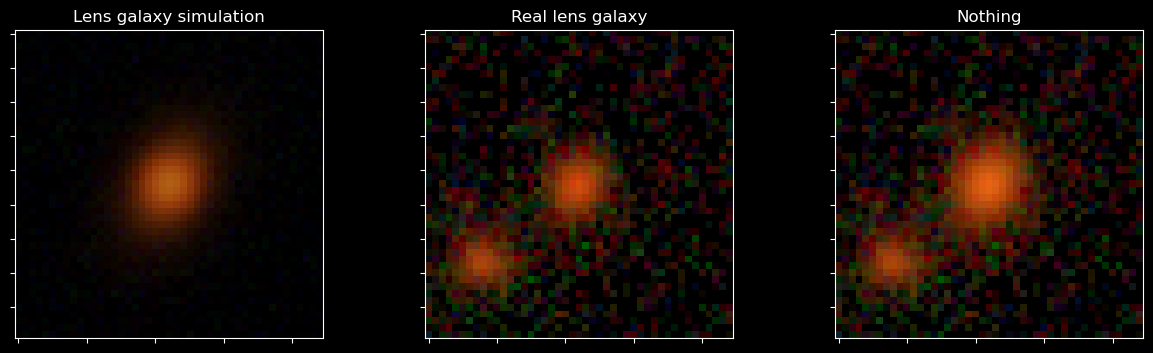

1260445496
4.299015785808442 0.9949507877609999


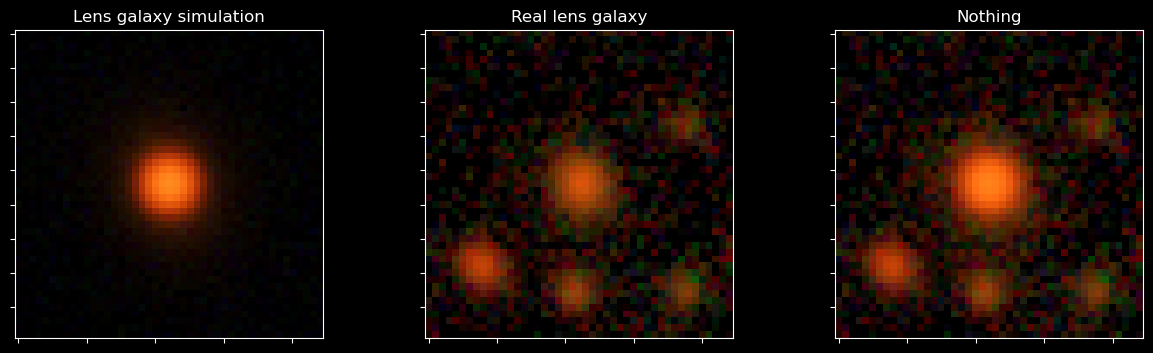

1059475070
2.0740504974657927 1.000014542388


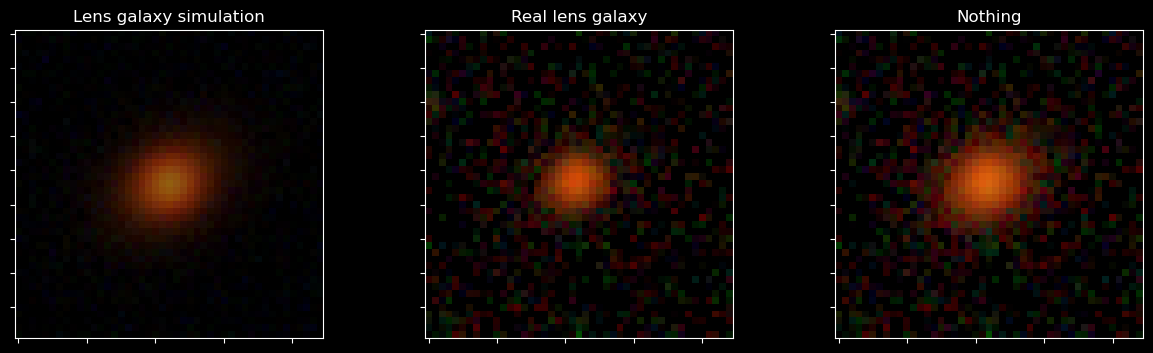

1040906127
1.4075606381776993 1.061096905485


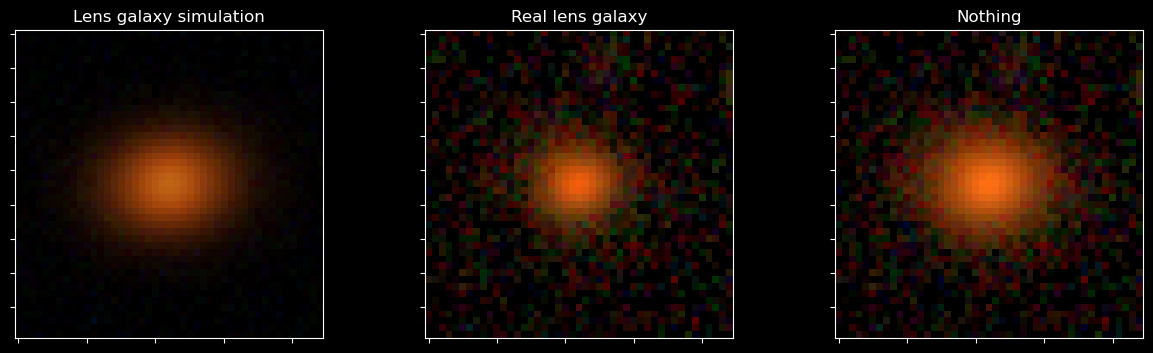

1135127741
3.439014250781552 1.689318317997


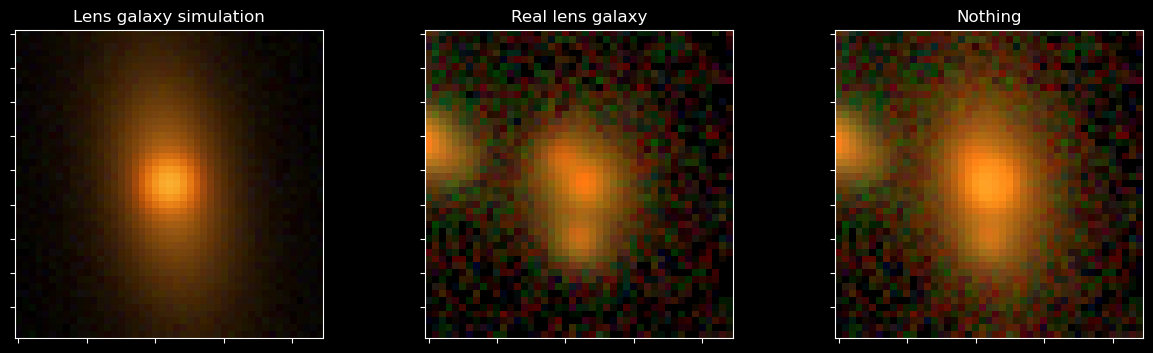

1215711356
3.586756856283059 1.450750362525


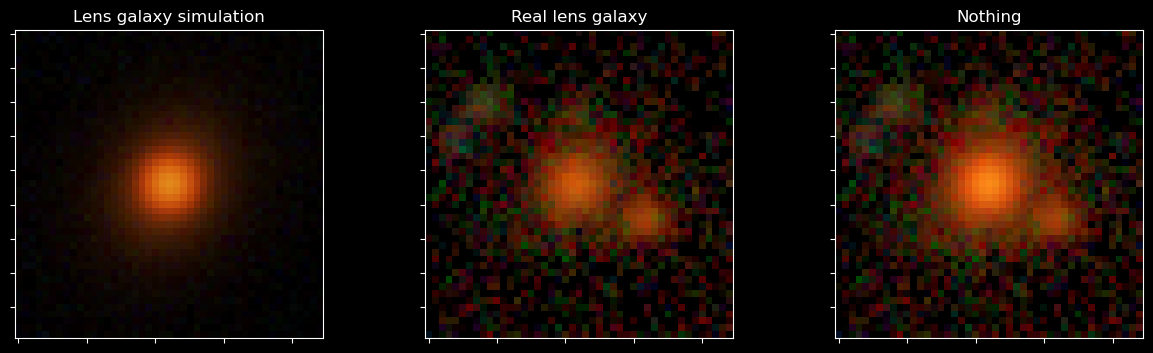

1270451499
3.72259239838454 1.827653584392


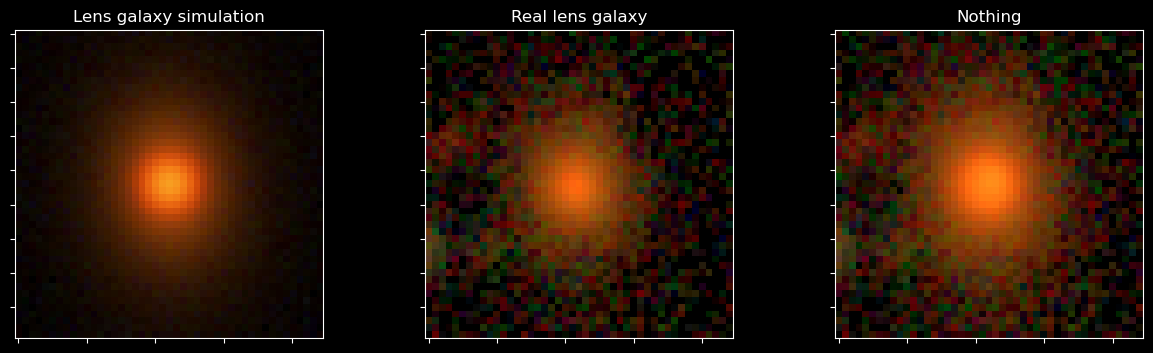

1209024892
2.5111725903423188 1.5114758076719998


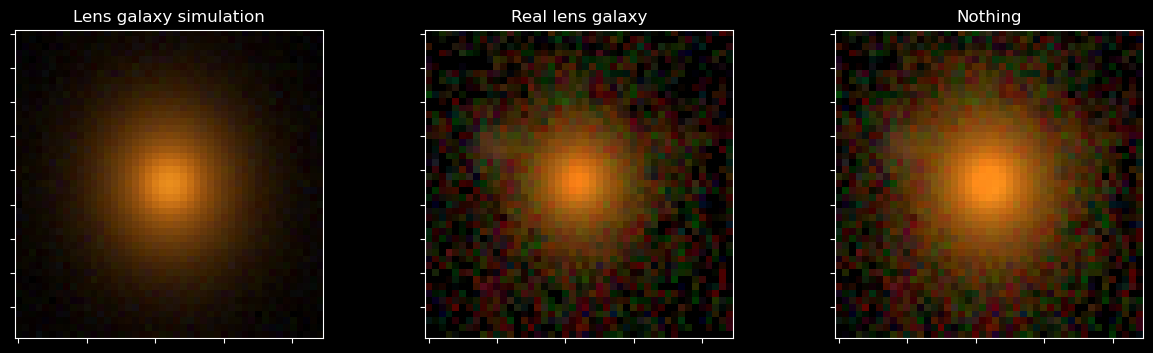

1079401610
0.9711854484368043 1.307817842625


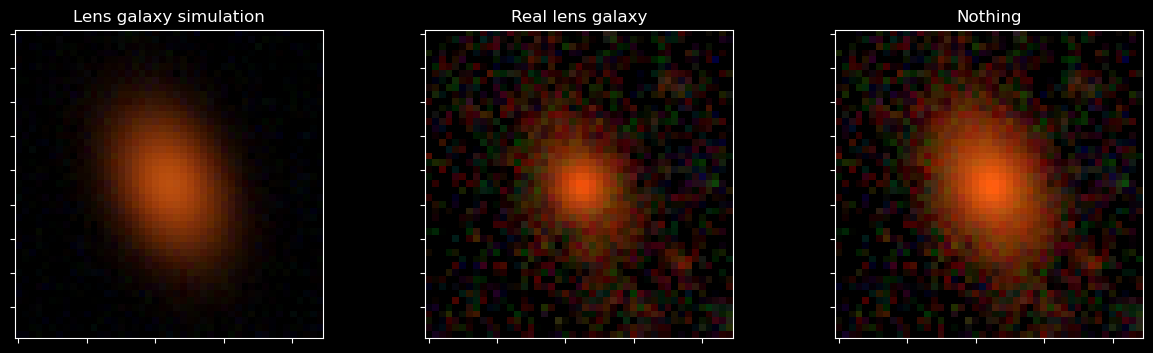

1070062539
3.3093638461674137 1.077858811395


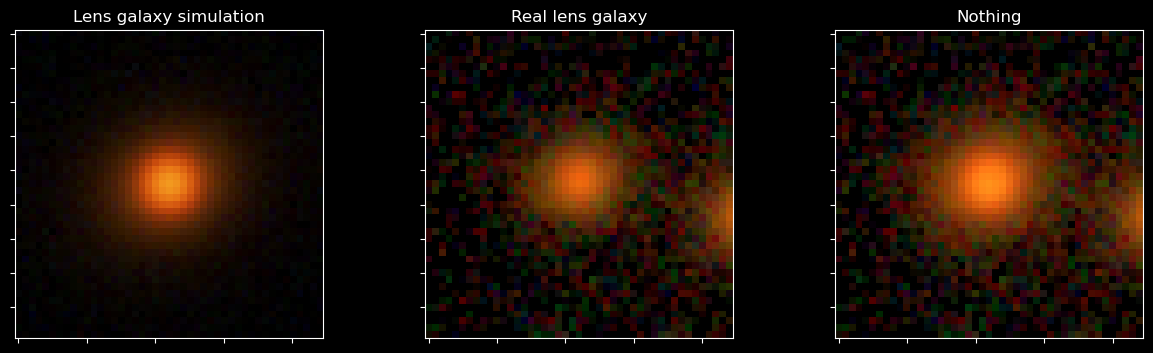

1083917959
3.3529822760463146 1.237052531556


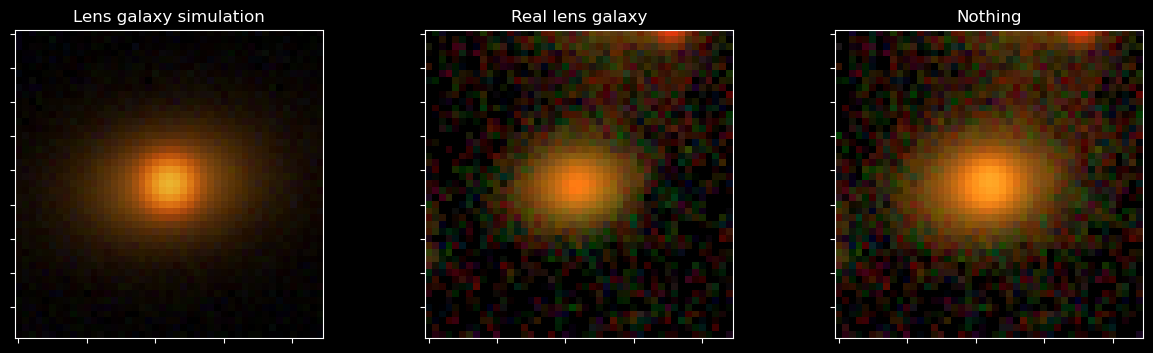

1119674786
0.9269414798519491 1.2283657762590001


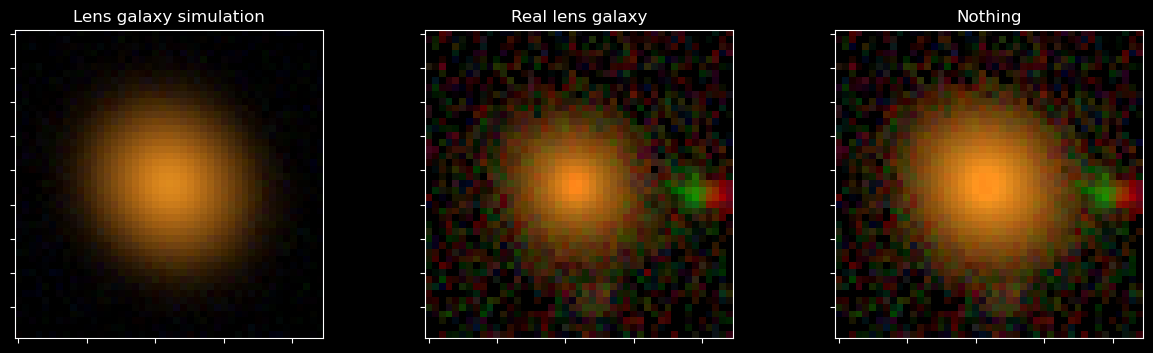

1055786680
2.7302616505391506 0.897180505551


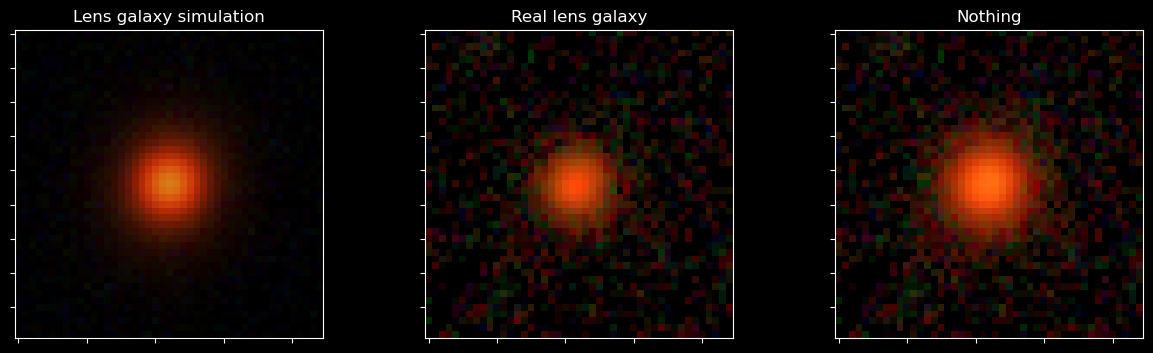

1097437111
1.9070707435489072 1.8530997325379999


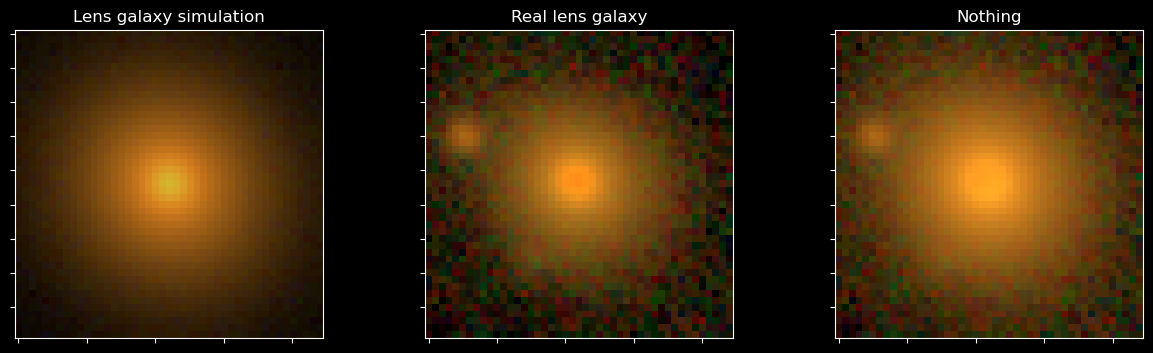

1182024400
1.993678627959173 1.202749496784


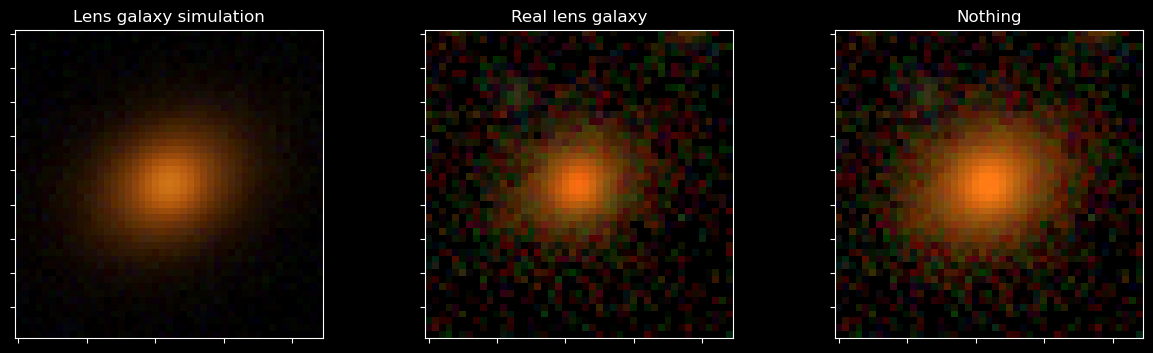

1051826612
1.39748767938876 1.0331342207729999


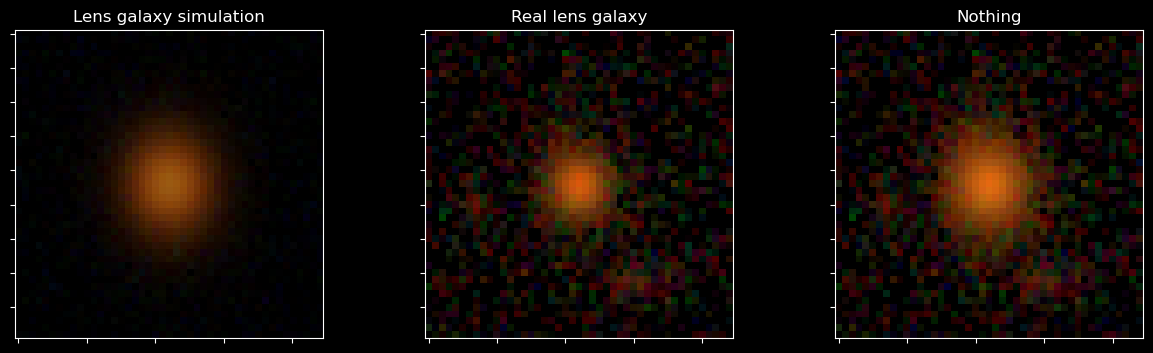

1112199630
1.5987112677438122 1.3842871877429999


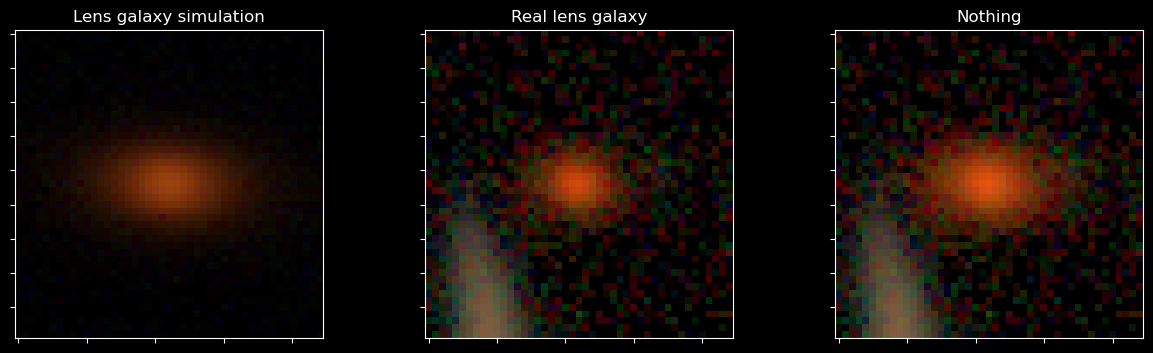

1119328686
2.23054246202726 1.3028399698139999


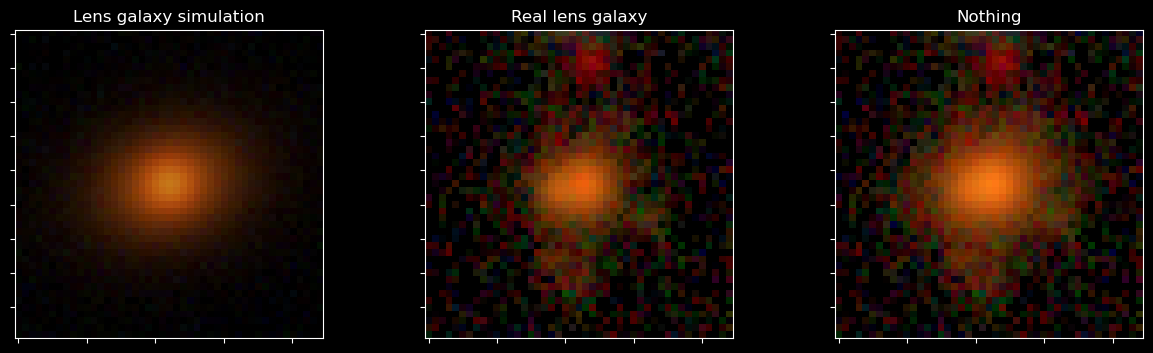

1100420454
3.1432138981328226 1.3202579982419997


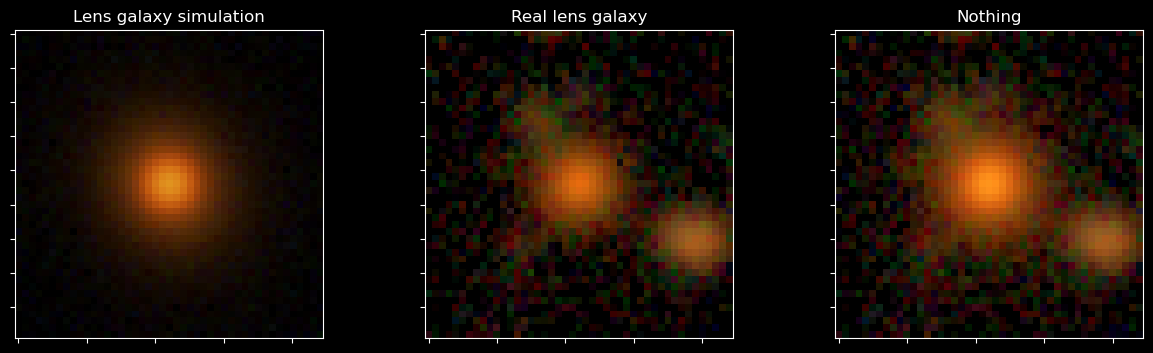

1229064908
2.869700085962725 0.883401073011


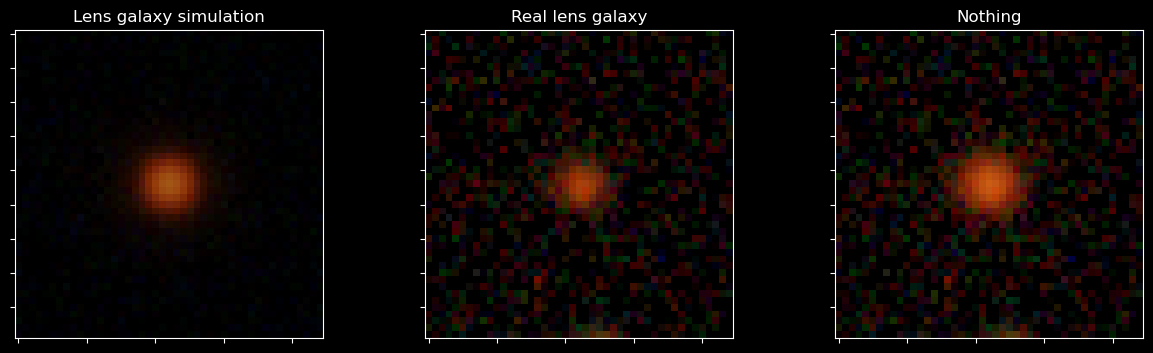

In [12]:
seed, num_sim, double, filename = 2, 20, False, 'other' # 4 2 False other
if(cluster):
    seed, num_sim, double, filename = sys.argv[1], sys.argv[2], sys.argv[3], sys.argv[4] 
    double = bool(strtobool(double))
run_everything(int(seed), int(num_sim), double, filename)
